In [77]:
# loading required packeges
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [47]:
# downloading and cleaning data
league_20_21 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/2021/E0.csv') %>% 
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>% 
    select(goal_diff)

league_19_20 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1920/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>%
    select(goal_diff)

league_17_18 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1718/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>% 
    select(goal_diff)

league_16_17 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1617/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>%
    select(goal_diff)

In [56]:
old_coach <- rbind(league_16_17, league_17_18) %>% 
    mutate(result = case_when(goal_diff < 0 ~ 'Lose', goal_diff == 0 ~ 'Draw', goal_diff > 0 ~ 'Win'), 
        coach = 'old') 

new_coach <- rbind(league_19_20, league_20_21) %>% 
    mutate(result = case_when(goal_diff < 0 ~ 'Lose', goal_diff == 0 ~ 'Draw', goal_diff > 0 ~ 'Win'), 
        coach = 'new')


league_results <- rbind(old_coach, new_coach)
head(league_results)

goal_diff,result,coach
2,Win,old
2,Win,old
1,Win,old
-1,Lose,old
-2,Lose,old
3,Win,old


In [135]:
# find observed statistics for each parameter
obs_stat <- league_results %>%
    group_by(coach) %>%
    summarize(mean = mean(goal_diff) %>% round(3), 
             sd = sd(goal_diff) %>% round(3), 
             n = n())
obs_stat

# find obersed difference
# in standard deviations
obs_diff_sd <- obs_stat$sd[1] - obs_stat$sd[2]
paste("Standard deviation of difference in goals: ", obs_diff_sd)
# in means
obs_diff_mean <- obs_stat$mean[1] - obs_stat$mean[2]
paste('Mean of difference in goals: ', obs_diff_mean)

coach,mean,sd,n
new,0.776,1.916,76
old,0.855,1.538,76


[1] "Standard deviation of difference in goals:  0.378"

[1] "Mean of difference in goals:  -0.079"

Warning message:
“Removed 12 rows containing missing values (geom_bar).”

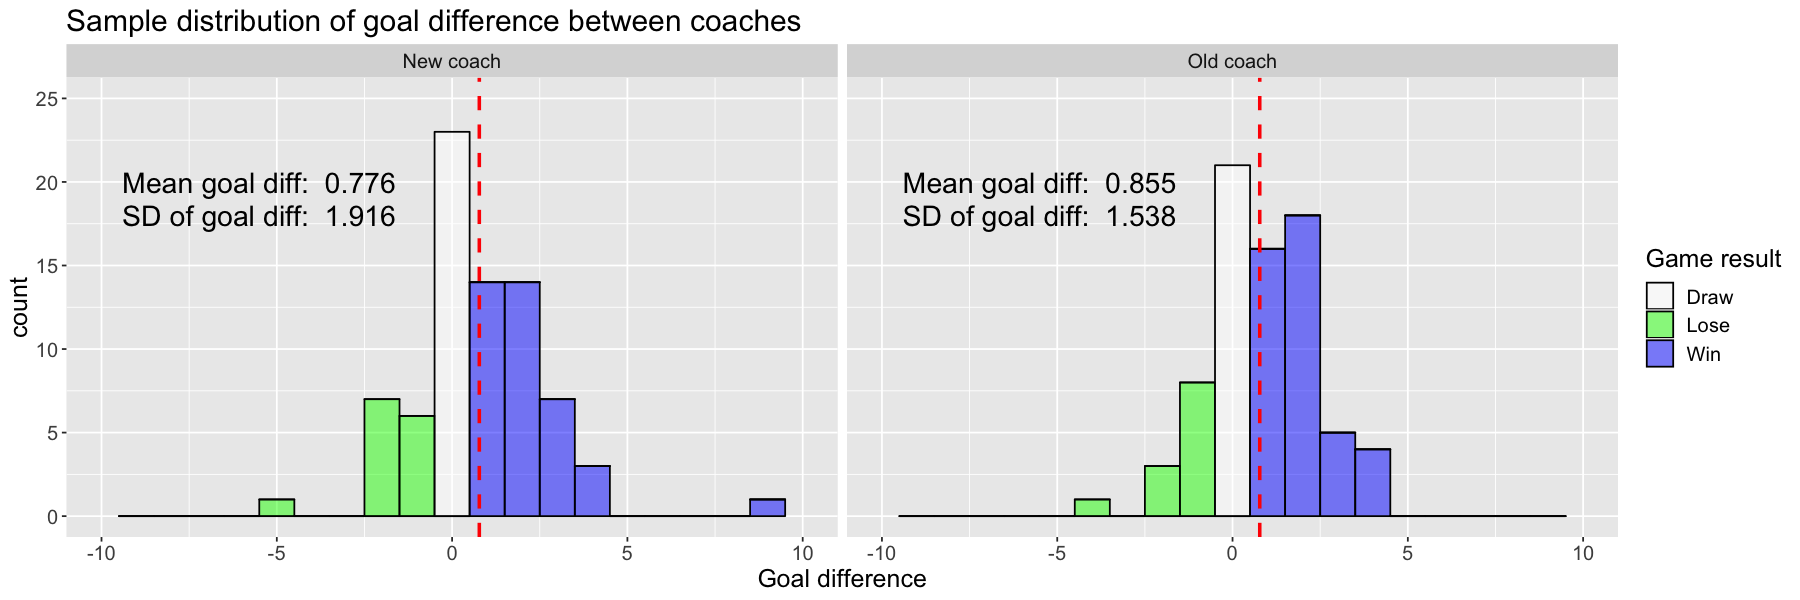

In [159]:
goal_diff_before_fired_sample_distribution <- league_results %>%   
ggplot() +
geom_histogram(aes(x = goal_diff, fill = result), color = "black", binwidth = 1, alpha=0.5) +
scale_fill_manual(values=c('white', 'green', 'blue')) +
labs(x = "Goal difference", fill='Game result') + 
lims(x=c(-10, 10), y=c(0, 25)) +
ggtitle("Sample distribution of goal difference between coaches") +
theme(text = element_text(size = 15)) +
facet_wrap(~coach, labeller=as_labeller(c('new'='New coach', old='Old coach'))) +
geom_vline(data=data.frame(coach='new'), aes(xintercept = obs_stat$mean[1]), color = "red", linetype = "dashed", size = 1) + 
geom_text(data=data.frame(coach='new'), x = -5.5, y = 20, label = paste("Mean goal diff: ", obs_stat$mean[1]), size = 6) +
geom_text(data=data.frame(coach='new'), x = -5.5, y = 18, label = paste("SD of goal diff: ", obs_stat$sd[1]), size = 6) +
geom_vline(data=data.frame(coach='old'), aes(xintercept = obs_stat$mean[1]), color = "red", linetype = "dashed", size = 1) + 
geom_text(data=data.frame(coach='old'), x = -5.5, y = 20, label = paste("Mean goal diff: ", obs_stat$mean[2]), size = 6) +
geom_text(data=data.frame(coach='old'), x = -5.5, y = 18, label = paste("SD of goal diff: ", obs_stat$sd[2]), size = 6)

options(repr.plot.width = 15, repr.plot.height = 5)
goal_diff_before_fired_sample_distribution

replicate,stat
1,0.15789474
2,-0.42105263
3,-0.36842105
4,-0.23684211
5,-0.15789474
6,0.07894737


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


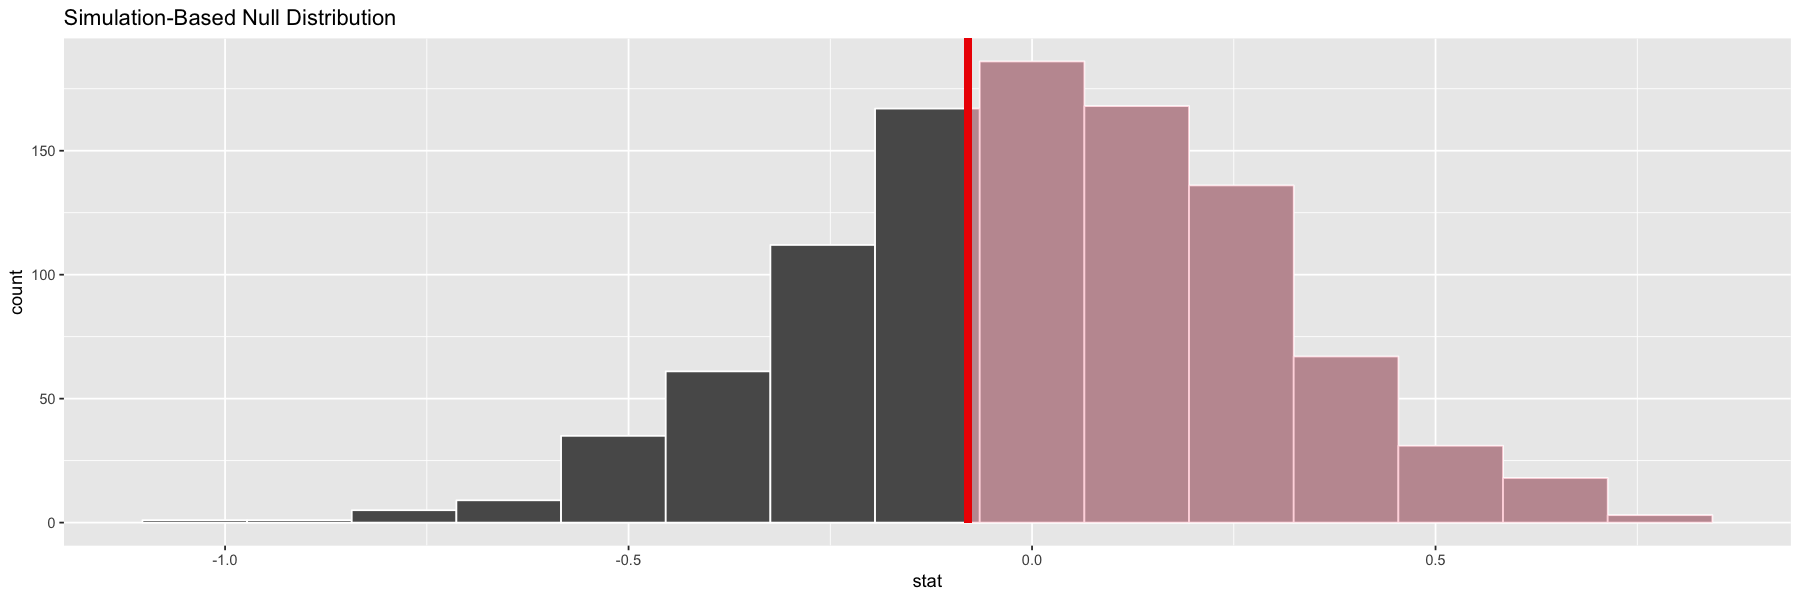

In [246]:
# hypothesis testing: bootstrap
# infer package abstracts the bootstrap process in `generate()`
set.seed(2001)

# construct null model
null_dist_bt <- 
    league_results %>%
    specify(formula = goal_diff ~ coach) %>%
    hypothesize(null = 'independence') %>%
    generate(reps = 1000, type = 'permute') %>%
    calculate(stat = 'diff in means', order = c('new', 'old'))
head(null_dist_bt)

# plot the observed difference in the null model


In [173]:
# hypothesis testing: asymptotics

# standard errors
obs_diff_se <- sqrt(obs_stat$sd[1]^2 / obs_stat$n[1] + obs_stat$sd[2]^2 / obs_stat$n[2])

# test statistic
ts <- obs_diff_mean / obs_diff_se

# obtain p_value
p_value_as <- pnorm(ts, lower.tail = FALSE)
p_value_as

[1] 0.6103808

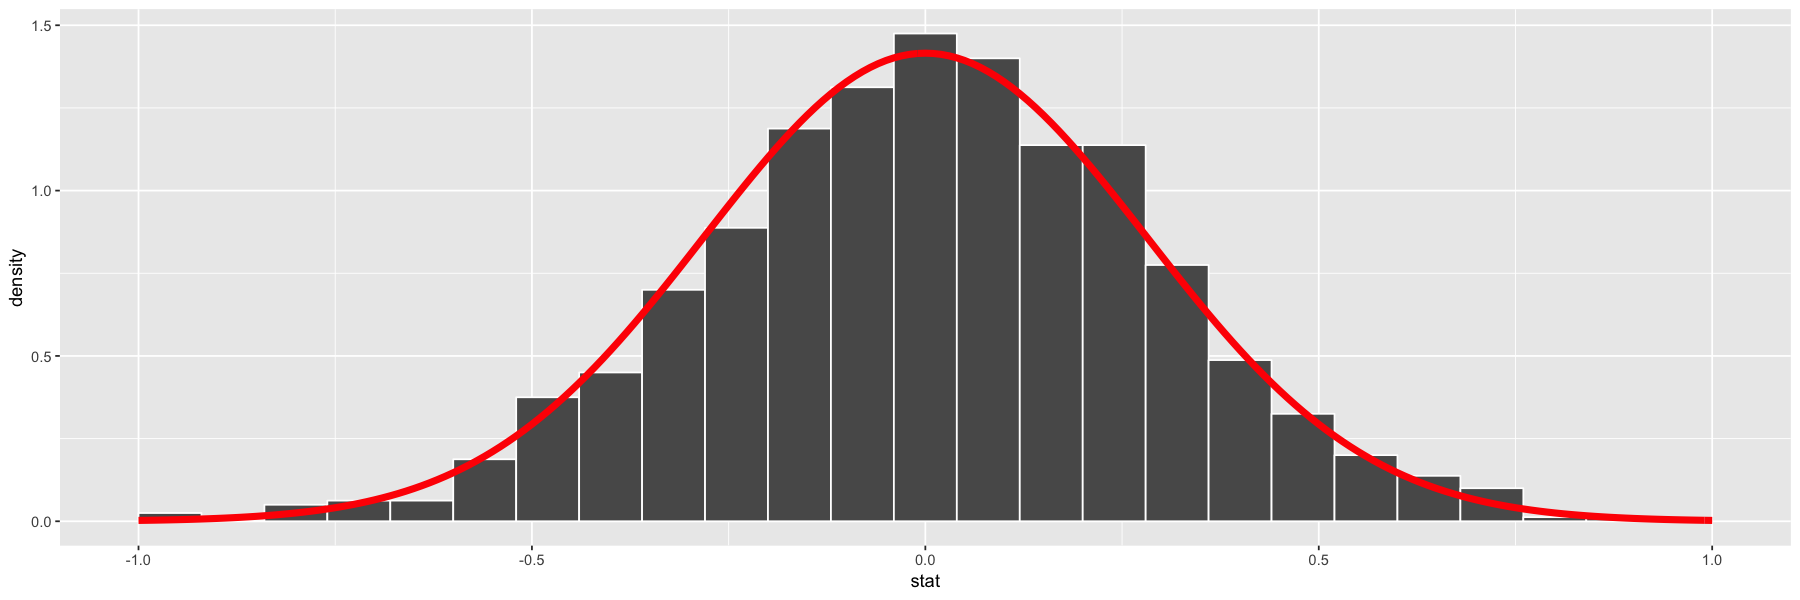

In [251]:
null_dist <- ggplot() +
    geom_histogram(data=null_dist_bt, aes(x=stat, y=..density..), binwidth=0.08, color='white') +
    geom_line(data = tibble(x = seq(-1, 1, 0.01), 
                            density = dnorm(x, 0, obs_diff_se)), 
              aes(x = x, y = density), color = "red", lwd = 2)
null_dist 